In [1]:
print("Hello")

Hello


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifier
from sklearn.neighbors import RadiusNeighborsClassifier



PATH_MON = r"D:/Dissertation 2025/Result2/Monday_clean.csv"
PATH_FRI = r"D:/Dissertation 2025/Result2/Friday_clean.csv"

LABEL_COL = "Label"

BENIGN_LABEL = None 

N_SAMPLES_PER_DAY = 50_000   

RADIUS = 5.0
RANDOM_STATE = 42


def load_day(path, label_col, benign_label=None, n_samples=None):
    
    print(f"\n[INFO] Loading {path}")
    
    if n_samples is not None:
        df = pd.read_csv(path, nrows=n_samples)
        print(f"[INFO] Read first {n_samples} rows.")
    else:
        df = pd.read_csv(path)
        print(f"[INFO] Read full file with {len(df)} rows.")

    df = df.dropna(subset=[label_col])

    y = df[label_col]
    if benign_label is not None:
        y = (y != benign_label).astype(int)
    else:
        y = y.astype(int)

    X = df.drop(columns=[label_col])
    X = X.select_dtypes(include=[np.number]).astype(np.float32)

    print(f"[INFO] Shape after processing: X={X.shape}, y={y.shape}")
    return X, y


def standardize_train_test(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


def evaluate_model(name, clf, X_train, y_train, X_test, y_test):
    """
    Fit model and print accuracy, precision, recall, F1, confusion matrix.
    Uses average='binary' (0=benign, 1=attack).
    """
    print(f"\n===== {name} =====")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", pos_label=1, zero_division=0
    )
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion matrix [[TN, FP],[FN, TP]]:")
    print(cm)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "cm": cm,
    }


# LOAD MONDAY & FRIDAY 

X_mon, y_mon = load_day(PATH_MON, LABEL_COL, benign_label=BENIGN_LABEL, n_samples=N_SAMPLES_PER_DAY)
X_fri, y_fri = load_day(PATH_FRI, LABEL_COL, benign_label=BENIGN_LABEL, n_samples=N_SAMPLES_PER_DAY)

common_cols = sorted(list(set(X_mon.columns) & set(X_fri.columns)))
X_mon = X_mon[common_cols]
X_fri = X_fri[common_cols]

print(f"\n[INFO] Using {len(common_cols)} common numeric features.")


# DEFINE MODELS

models = {
    "PassiveAggressive": PassiveAggressiveClassifier(max_iter=1000, random_state=RANDOM_STATE),
    "RidgeClassifier": RidgeClassifier(),
    "RadiusNeighbors": RadiusNeighborsClassifier(
        radius=RADIUS,
        outlier_label=0,  
        weights='uniform'
    )
}


print("TRAIN: MONDAY  | TEST: FRIDAY")

X_mon_scaled, X_fri_scaled = standardize_train_test(X_mon, X_fri)

results_mon_to_fri = {}

for name, clf in models.items():
    try:
        res = evaluate_model(f"{name} (Mon→Fri)", clf, X_mon_scaled, y_mon, X_fri_scaled, y_fri)
        results_mon_to_fri[name] = res
    except Exception as e:
        print(f"[ERROR] {name} (Mon→Fri) failed: {e}")


# TRAIN ON FRIDAY -> TEST ON MONDAY

print("\n========================")
print("TRAIN: FRIDAY | TEST: MONDAY")
print("========================")

X_fri_scaled2, X_mon_scaled2 = standardize_train_test(X_fri, X_mon)

results_fri_to_mon = {}

for name, clf in models.items():
    try:
        res = evaluate_model(f"{name} (Fri→Mon)", clf, X_fri_scaled2, y_fri, X_mon_scaled2, y_mon)
        results_fri_to_mon[name] = res
    except Exception as e:
        print(f"[ERROR] {name} (Fri→Mon) failed: {e}")


# QUICK SUMMARY TABLE

def summarize(results_dict, tag):
    rows = []
    for name, res in results_dict.items():
        rows.append({
            "Model": name,
            "Setting": tag,
            "Accuracy": res["accuracy"],
            "Precision": res["precision"],
            "Recall": res["recall"],
            "F1": res["f1"],
        })
    return rows

summary_rows = []
summary_rows += summarize(results_mon_to_fri, "Mon→Fri")
summary_rows += summarize(results_fri_to_mon, "Fri→Mon")

summary_df = pd.DataFrame(summary_rows)
print("\n=========== SUMMARY (Cross-Day) ===========")
print(summary_df.to_string(index=False))



[INFO] Loading D:/Dissertation 2025/Result2/Monday_clean.csv
[INFO] Read first 50000 rows.
[INFO] Shape after processing: X=(50000, 80), y=(50000,)

[INFO] Loading D:/Dissertation 2025/Result2/Friday_clean.csv
[INFO] Read first 50000 rows.
[INFO] Shape after processing: X=(50000, 80), y=(50000,)

[INFO] Using 80 common numeric features.

TRAIN: MONDAY  | TEST: FRIDAY

===== PassiveAggressive (Mon→Fri) =====
[ERROR] PassiveAggressive (Mon→Fri) failed: The number of classes has to be greater than one; got 1 class

===== RidgeClassifier (Mon→Fri) =====
Accuracy : 1.0000
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000
Confusion matrix [[TN, FP],[FN, TP]]:
[[49998     0]
 [    2     0]]

===== RadiusNeighbors (Mon→Fri) =====
Accuracy : 1.0000
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000
Confusion matrix [[TN, FP],[FN, TP]]:
[[49998     0]
 [    2     0]]

TRAIN: FRIDAY | TEST: MONDAY

===== PassiveAggressive (Fri→Mon) =====


d:\Dissertation 2025\Notebooks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
d:\Dissertation 2025\Notebooks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Accuracy : 1.0000
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000
Confusion matrix [[TN, FP],[FN, TP]]:
[[50000]]

===== RidgeClassifier (Fri→Mon) =====
Accuracy : 1.0000
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000
Confusion matrix [[TN, FP],[FN, TP]]:
[[50000]]

===== RadiusNeighbors (Fri→Mon) =====
Accuracy : 1.0000
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000
Confusion matrix [[TN, FP],[FN, TP]]:
[[50000]]

=========== SUMMARY (Cross-Day) ===========
            Model Setting  Accuracy  Precision  Recall  F1
  RidgeClassifier Mon→Fri   0.99996        0.0     0.0 0.0
  RadiusNeighbors Mon→Fri   0.99996        0.0     0.0 0.0
PassiveAggressive Fri→Mon   1.00000        0.0     0.0 0.0
  RidgeClassifier Fri→Mon   1.00000        0.0     0.0 0.0
  RadiusNeighbors Fri→Mon   1.00000        0.0     0.0 0.0


d:\Dissertation 2025\Notebooks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


d:\Dissertation 2025\Notebooks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
d:\Dissertation 2025\Notebooks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
d:\Dissertation 2025\Notebooks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


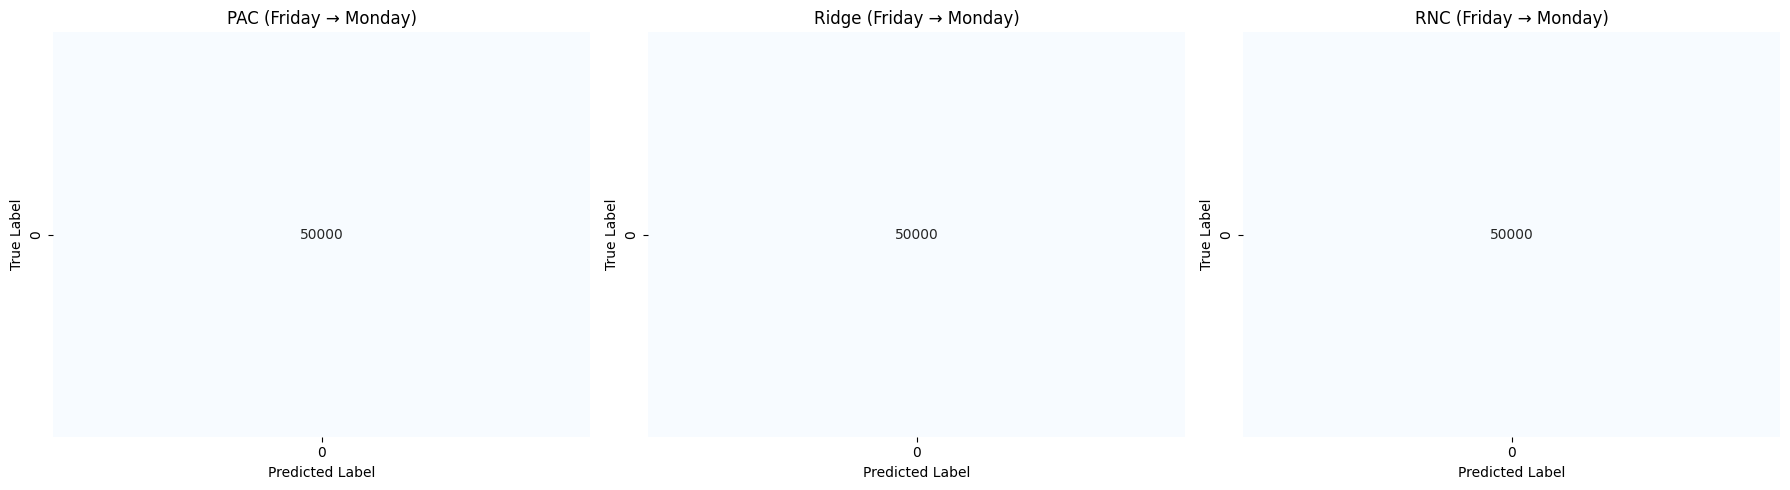

Figure saved as fig_4_4_confusion_PAC_Ridge_RNC.png


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Refit Models on Fri→Mon
pac_model = PassiveAggressiveClassifier(max_iter=1000, random_state=42)
ridge_model = RidgeClassifier()
rnc_model = RadiusNeighborsClassifier(radius=RADIUS, outlier_label=0)

# Fit using Friday -> Test on Monday
pac_model.fit(X_fri_scaled2, y_fri)
ridge_model.fit(X_fri_scaled2, y_fri)
rnc_model.fit(X_fri_scaled2, y_fri)

# Predictions
y_pred_pac = pac_model.predict(X_mon_scaled2)
y_pred_ridge = ridge_model.predict(X_mon_scaled2)
y_pred_rnc = rnc_model.predict(X_mon_scaled2)

# Compute Confusion Matrices
cm_pac = confusion_matrix(y_mon, y_pred_pac)
cm_ridge = confusion_matrix(y_mon, y_pred_ridge)
cm_rnc = confusion_matrix(y_mon, y_pred_rnc)

#  Plot all 3 in one figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

titles = [
    "PAC (Friday → Monday)",
    "Ridge (Friday → Monday)",
    "RNC (Friday → Monday)"
]

cms = [cm_pac, cm_ridge, cm_rnc]

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax, cbar=False)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()

# Save the figure
plt.savefig("fig_4_4_confusion_PAC_Ridge_RNC.png", dpi=300)
plt.show()

print("Figure saved as fig_4_4_confusion_PAC_Ridge_RNC.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

# --- Train models on Friday (X_fri_scaled2, y_fri) and test on Monday (X_mon_scaled2) ---

models = {
    "LR": LogisticRegression(max_iter=2000, n_jobs=-1),
    "RF": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "XGB": XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist"  
    ),
    "PAC": PassiveAggressiveClassifier(max_iter=1000, random_state=42),
    "Ridge": RidgeClassifier(),
    "RNC": RadiusNeighborsClassifier(
        radius=5.0,
        outlier_label=0,   # predict benign if no neighbours found
        weights='uniform'
    )
}

fps = {}
accs = {}

for name, clf in models.items():
    print(f"\n[INFO] Training {name} on Friday and testing on Monday...")
    clf.fit(X_fri_scaled2, y_fri)
    y_pred = clf.predict(X_mon_scaled2)

    cm = confusion_matrix(y_mon, y_pred, labels=[0, 1])
    # cm shape: [[TN, FP],
    #            [FN, TP]]
    tn, fp, fn, tp = cm.ravel()

    fps[name] = fp
    accs[name] = (tn + tp) / (tn + fp + fn + tp)

    print(f"{name} confusion matrix:\n{cm}")
    print(f"{name} Accuracy (Fri→Mon): {accs[name]:.4f}")
    print(f"{name} False Positives (Fri→Mon): {fp}")



[INFO] Training LR on Friday and testing on Monday...
LR confusion matrix:
[[50000     0]
 [    0     0]]
LR Accuracy (Fri→Mon): 1.0000
LR False Positives (Fri→Mon): 0

[INFO] Training RF on Friday and testing on Monday...
RF confusion matrix:
[[50000     0]
 [    0     0]]
RF Accuracy (Fri→Mon): 1.0000
RF False Positives (Fri→Mon): 0

[INFO] Training XGB on Friday and testing on Monday...
XGB confusion matrix:
[[50000     0]
 [    0     0]]
XGB Accuracy (Fri→Mon): 1.0000
XGB False Positives (Fri→Mon): 0

[INFO] Training PAC on Friday and testing on Monday...
PAC confusion matrix:
[[50000     0]
 [    0     0]]
PAC Accuracy (Fri→Mon): 1.0000
PAC False Positives (Fri→Mon): 0

[INFO] Training Ridge on Friday and testing on Monday...
Ridge confusion matrix:
[[50000     0]
 [    0     0]]
Ridge Accuracy (Fri→Mon): 1.0000
Ridge False Positives (Fri→Mon): 0

[INFO] Training RNC on Friday and testing on Monday...
RNC confusion matrix:
[[50000     0]
 [    0     0]]
RNC Accuracy (Fri→Mon): 1.

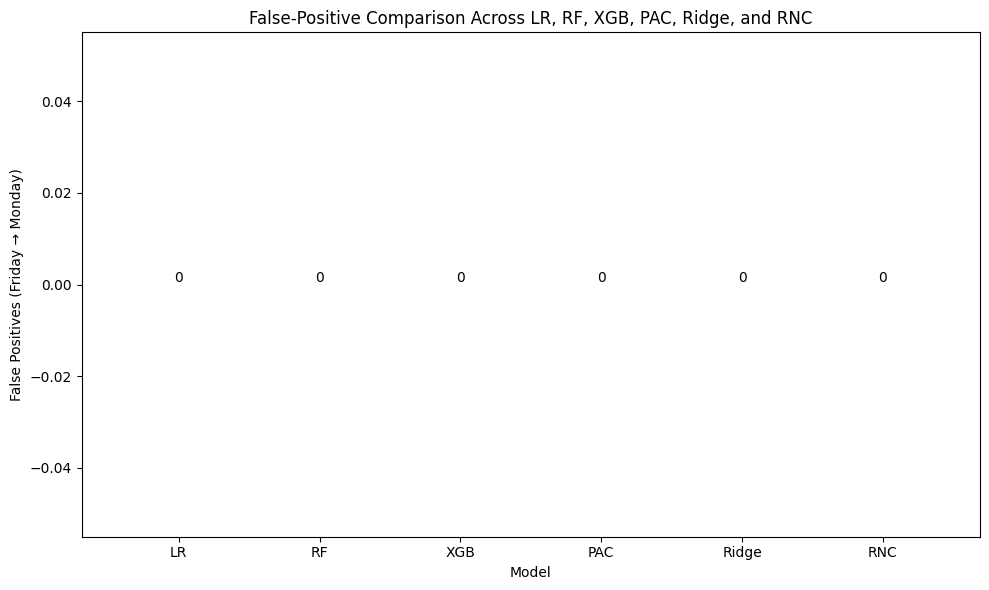

Figure 4.5 saved as fig_4_5_fp_comparison.png


In [ ]:
# Create bar chart of FP counts 

model_names = list(fps.keys())
fp_values = [fps[m] for m in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, fp_values)

plt.xlabel("Model")
plt.ylabel("False Positives (Friday → Monday)")
plt.title("False-Positive Comparison Across LR, RF, XGB, PAC, Ridge, and RNC")

# Add FP values on top of each bar
for bar, fp in zip(bars, fp_values):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(fp),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.savefig("fig_4_5_fp_comparison.png", dpi=300)
plt.show()

print("Figure 4.5 saved as fig_4_5_fp_comparison.png")


In [ ]:
# Cross-day FP comparison: LR, RF, XGB, PAC, Ridge, RNC


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import (
    LogisticRegression,
    PassiveAggressiveClassifier,
    RidgeClassifier,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

from xgboost import XGBClassifier


# USER SETTINGS

PATH_MON = r"D:/Dissertation 2025/Result2/Monday_clean.csv"
PATH_FRI = r"D:/Dissertation 2025/Result2/Friday_clean.csv"

LABEL_COL = "Label"       # must be 0/1 already
N_MON = 100_000           # how many Monday rows to use (test)
N_FRI = 100_000           # how many Friday rows to use (train)
RADIUS = 5.0              # radius for RNC
RANDOM_STATE = 42



def load_day(path, label_col, n_rows=None, shuffle=True):
    """Load one day's CSV, keep only numeric features, and return X, y."""
    print(f"\n[INFO] Loading from {path}")
    df = pd.read_csv(path)

    if shuffle:
        df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    if n_rows is not None and len(df) > n_rows:
        df = df.head(n_rows)
        print(f"[INFO] Using first {n_rows} shuffled rows")

    # Drop missing labels
    df = df.dropna(subset=[label_col])

    y = df[label_col].astype(int)
    X = df.drop(columns=[label_col])
    X = X.select_dtypes(include=[np.number]).astype(np.float32)

    print(f"[INFO] Shape X={X.shape}, y={y.shape}")
    print("[INFO] Label distribution:")
    print(y.value_counts())
    return X, y


def stratified_downsample(X, y, max_samples):
    if max_samples is None or len(X) <= max_samples:
        return X, y

    print(f"[INFO] Stratified downsampling to {max_samples} rows.")
    df_tmp = X.copy()
    df_tmp[LABEL_COL] = y.values

    # For binary labels 0/1
    n_classes = df_tmp[LABEL_COL].nunique()
    per_class = max_samples // n_classes

    df_sampled = (
        df_tmp.groupby(LABEL_COL, group_keys=False)
              .apply(lambda g: g.sample(
                  n=min(len(g), per_class),
                  random_state=RANDOM_STATE))
    )

    y_s = df_sampled[LABEL_COL].astype(int)
    X_s = df_sampled.drop(columns=[LABEL_COL])

    print(f"[INFO] After downsample X={X_s.shape}, y={y_s.shape}")
    print("[INFO] New label distribution:")
    print(y_s.value_counts())
    return X_s, y_s


def scale_train_test(X_train, X_test):
    """Fit scaler on TRAIN only, apply to both."""
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    return X_train_s, X_test_s



# Load full days (shuffled), then limit rows
X_fri, y_fri = load_day(PATH_FRI, LABEL_COL, n_rows=N_FRI, shuffle=True)
X_mon, y_mon = load_day(PATH_MON, LABEL_COL, n_rows=N_MON, shuffle=True)

X_fri, y_fri = stratified_downsample(X_fri, y_fri, max_samples=N_FRI)

common_cols = sorted(set(X_fri.columns) & set(X_mon.columns))
X_fri = X_fri[common_cols]
X_mon = X_mon[common_cols]

print(f"\n[INFO] Using {len(common_cols)} common numeric features.")

X_fri_scaled, X_mon_scaled = scale_train_test(X_fri, X_mon)


models = {
    "LR": LogisticRegression(max_iter=2000, n_jobs=-1),
    "RF": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    "XGB": XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_STATE,
    ),
    "PAC": PassiveAggressiveClassifier(max_iter=1000, random_state=RANDOM_STATE),
    "Ridge": RidgeClassifier(),
    "RNC": RadiusNeighborsClassifier(
        radius=RADIUS,
        outlier_label=0,
        weights="uniform",
    ),
}



fps = {}
accs = {}

for name, clf in models.items():
    print(f"\n[INFO] Training {name} on Friday and testing on Monday...")
    clf.fit(X_fri_scaled, y_fri)
    y_pred = clf.predict(X_mon_scaled)

    cm = confusion_matrix(y_mon, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    fps[name] = int(fp)
    accs[name] = (tn + tp) / (tn + fp + fn + tp)

    print(f"{name} confusion matrix (labels [0,1]):\n{cm}")
    print(f"{name} Accuracy (Fri→Mon): {accs[name]:.6f}")
    print(f"{name} False Positives (Fri→Mon): {fp}")
    print("-" * 60)


#PLOT FIGURE 4.5 – FALSE POSITIVES BAR CHART

model_names = list(fps.keys())
fp_values = [fps[m] for m in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, fp_values)

plt.xlabel("Model")
plt.ylabel("False Positives (Friday → Monday)")
plt.title("False-Positive Comparison Across LR, RF, XGB, PAC, Ridge, and RNC")

# Annotate bars with FP numbers
for bar, fp in zip(bars, fp_values):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(fp),
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.tight_layout()
plt.savefig("fig_4_5_fp_comparison.png", dpi=300)
plt.show()

print("\n[INFO] Figure 4.5 saved as fig_4_5_fp_comparison.png")
print("[INFO] False positives by model:", fps)



[INFO] Loading from D:/Dissertation 2025/Result2/Friday_clean.csv
[INFO] Using first 100000 shuffled rows
[INFO] Shape X=(100000, 80), y=(100000,)
[INFO] Label distribution:
Label
0    59007
1    40993
Name: count, dtype: int64

[INFO] Loading from D:/Dissertation 2025/Result2/Monday_clean.csv
[INFO] Using first 100000 shuffled rows
[INFO] Shape X=(100000, 80), y=(100000,)
[INFO] Label distribution:
Label
0    100000
Name: count, dtype: int64

[INFO] Using 80 common numeric features.

[INFO] Training LR on Friday and testing on Monday...
LR confusion matrix (labels [0,1]):
[[98006  1994]
 [    0     0]]
LR Accuracy (Fri→Mon): 0.980060
LR False Positives (Fri→Mon): 1994
------------------------------------------------------------

[INFO] Training RF on Friday and testing on Monday...
RF confusion matrix (labels [0,1]):
[[99999     1]
 [    0     0]]
RF Accuracy (Fri→Mon): 0.999990
RF False Positives (Fri→Mon): 1
------------------------------------------------------------

[INFO] Train

: 